In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("swapnilpanda/heart-sound-database")

print("Path to dataset files:", path)

100%|██████████| 173M/173M [00:17<00:00, 10.3MB/s] 

Extracting files...


Path to dataset files: /Users/furkanmelih/.cache/kagglehub/datasets/swapnilpanda/heart-sound-database/versions/1


In [4]:
! cd /Users/furkanmelih/.cache/kagglehub/datasets/swapnilpanda/heart-sound-database/versions/1 && ls

heart_sound


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [11]:
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.models import Sequential,Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,BatchNormalization, Activation, Input, concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

from keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow_io as tfio
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [24]:
epochs = 20

model_file_path = "best_model_file.hdf5"
checkpoint = ModelCheckpoint(model_file_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = tf.keras.callbacks.CSVLogger('Model.log')


initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model_file.hdf5

In [12]:
os.listdir(f'{path}/heart_sound')
data = os.path.join(f'{path}/heart_sound')
data

'/Users/furkanmelih/.cache/kagglehub/datasets/swapnilpanda/heart-sound-database/versions/1/heart_sound'

In [13]:
train_dir_path = os.path.join(data, 'train')
valid_dir_path = os.path.join(data, 'val')

In [14]:
train_dir_path

'/Users/furkanmelih/.cache/kagglehub/datasets/swapnilpanda/heart-sound-database/versions/1/heart_sound/train'

In [15]:
valid_dir_path

'/Users/furkanmelih/.cache/kagglehub/datasets/swapnilpanda/heart-sound-database/versions/1/heart_sound/val'

In [16]:
healthy = os.path.join(train_dir_path, 'healthy', 'a0009.wav')
unhealthy = os.path.join(train_dir_path, 'unhealthy', 'a0001.wav')

In [17]:
healthy

'/Users/furkanmelih/.cache/kagglehub/datasets/swapnilpanda/heart-sound-database/versions/1/heart_sound/train/healthy/a0009.wav'

In [18]:
unhealthy

'/Users/furkanmelih/.cache/kagglehub/datasets/swapnilpanda/heart-sound-database/versions/1/heart_sound/train/unhealthy/a0001.wav'

In [19]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    # wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

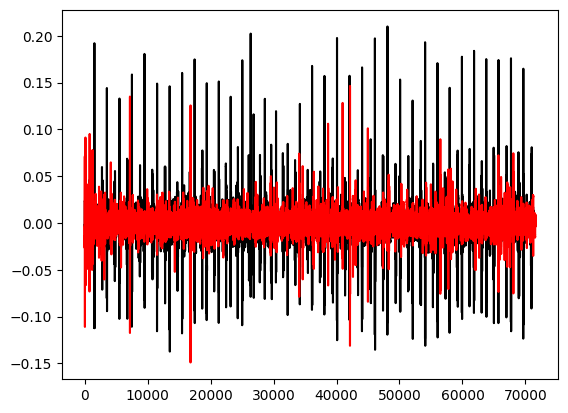

In [20]:
wave = load_wav_16k_mono(healthy)
nwave = load_wav_16k_mono(unhealthy)

plt.plot(nwave, color='black')
plt.plot(wave, color='red')
plt.show()

In [22]:
healthy_heart_train = tf.data.Dataset.list_files(train_dir_path+'/healthy'+'/*.wav')
unhealthy_heart_train = tf.data.Dataset.list_files(train_dir_path+'/unhealthy'+'/*.wav')
healthy_heart_valid = tf.data.Dataset.list_files(valid_dir_path+'/healthy'+'/*.wav')
unhealthy_heart_valid = tf.data.Dataset.list_files(valid_dir_path+'/unhealthy'+'/*.wav')

hhl_train = tf.data.Dataset.zip((healthy_heart_train, tf.data.Dataset.from_tensor_slices(tf.ones(len(healthy_heart_train)))))
uhl_train = tf.data.Dataset.zip((unhealthy_heart_train, tf.data.Dataset.from_tensor_slices(tf.zeros(len(unhealthy_heart_train)))))
train_data = hhl_train.concatenate(uhl_train)

hhl_valid = tf.data.Dataset.zip((healthy_heart_valid, tf.data.Dataset.from_tensor_slices(tf.ones(len(healthy_heart_valid)))))
uhl_valid = tf.data.Dataset.zip((unhealthy_heart_valid, tf.data.Dataset.from_tensor_slices(tf.zeros(len(unhealthy_heart_valid)))))
valid_data = hhl_valid.concatenate(uhl_valid)

train_data = train_data.concatenate(valid_data)
lengths = []
for f in os.listdir(os.path.join(train_dir_path, 'healthy')):
    tensor_wave = load_wav_16k_mono(os.path.join(train_dir_path, 'healthy', f))
    lengths.append(len(tensor_wave))

tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:40000]
    zero_padding = tf.zeros([40000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=80, frame_step=40)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

train_data = train_data.map(preprocess)
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(8)
train_data = train_data.prefetch(4)

train = train_data.take(400)
test = train_data.skip(400).take(43)
samples, labels = train.as_numpy_iterator().next()

print(samples.shape)
print(labels)

(8, 999, 65, 1)
[1. 1. 1. 1. 1. 1. 1. 1.]


2025-11-14 08:39:03.310792: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
def cnn():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape=(999, 65, 1)))
    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
optimizer = Adam(learning_rate=lr_schedule)
model0 = cnn()
model0.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model0.summary()